Подходит конец года, и команда CLion уже строит планы на следующий год! Чтобы подготовиться к предстоящему планированию, в нашу команду Data Science Research обращается Анастасия Казакова - тимлид C++ Marketing. Коллегу интересуют следующие вопросы:<br>
<br>
- Как дела у CLion в плане выручки и какая доля на рынке C++ разработчиков;<br>
- Какую выручку ожидать в следующем периоде;<br>
- Какие тренды среди C++ разработчиков наблюдаются сейчас;<br>
- Что пишут пользователи CLion на StackOverflow, с какими трудностями они сталкиваются при использовании CLion.<br>
<br>
Для исследования этих вопросов в вашем распоряжении есть 3 источника данных:<br>
<br>
- Данные продаж (sales.csv);<br>
- Опросные данные Developer Ecosystem 2019, 2020;<br>
- Текстовые данные вопросов / ответов на StackOverflow, которые доступны публично.<br>
<br>
<br>
Требования<br>
<br>
Ожидается, что итоговый анализ будет оформлен в виде аналитического отчета, отвечающего на вопросы. Формат документа может быть любым, удобным для вас: Google Docs, docx, pdf, html и.т.д.<br>
<br>
Отчет, как и код, обрабатывающий данные, генерирующий весь отчет или отдельные его части (графики, таблицы), необходимо запушить в свой репозиторий и приложить к нему ссылку. Сам код может быть на языке Python или R. Репозиторий также должен содержать файл README, описывающий воспроизводимость вычислений.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.stattools import pacf

### Посмотрим сначала на структуру выручки

Для этого нужны таблицы sales.csv и две таблицы с данными из опросов.

In [2]:
sales = pd.read_csv('sales.csv')

Unnamed: 0


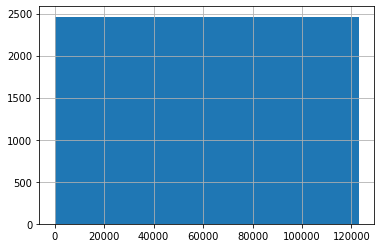

date


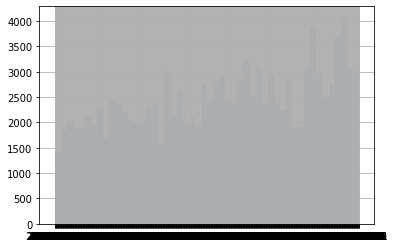

customer_id


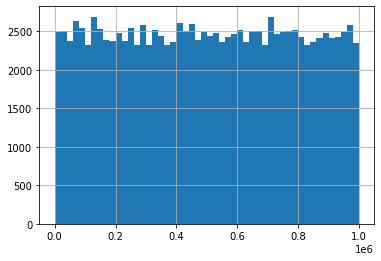

product


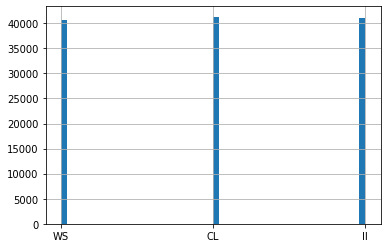

license_type


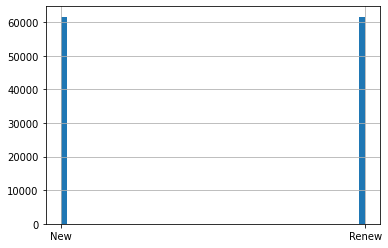

quantity


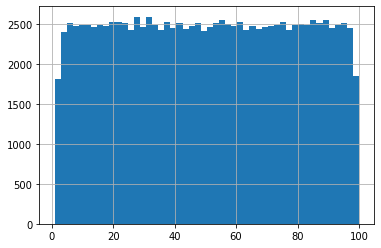

stock_price_usd


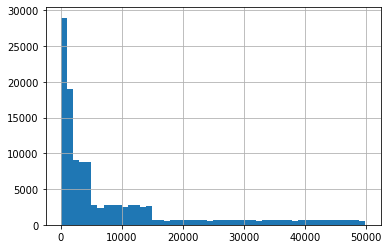

final_price_usd


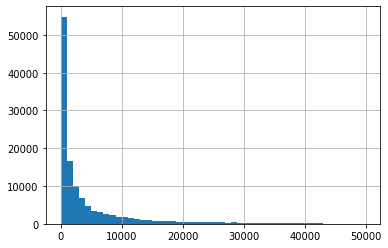

discount_percent


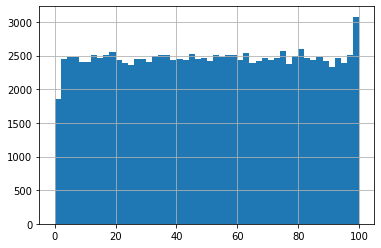

In [246]:
for col in sales.columns:
    print(col)
    sales[col].hist(bins=50)
    plt.show()

Интересно, а как зависит количсетво купленных лицензий от stock_price_usd?

<AxesSubplot:xlabel='stock_price_usd', ylabel='quantity'>

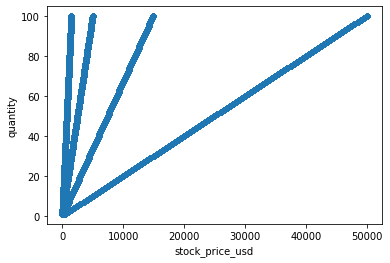

In [247]:
sales[['stock_price_usd', 'quantity']].plot.scatter(x='stock_price_usd', y='quantity')

Хммм... это похоже на то, что в stock_price_usd записано уже произведение стоимости лицензии на их количество. И,более того, цены всего четыре.

In [248]:
sales['price_of_one'] = sales['stock_price_usd']/sales['quantity']

<AxesSubplot:xlabel='price_of_one', ylabel='quantity'>

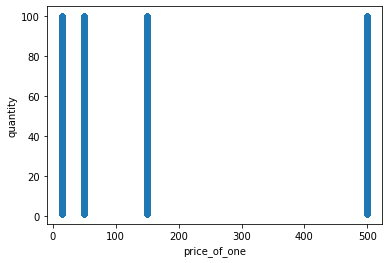

In [249]:
sales[['price_of_one', 'quantity']].plot.scatter(x='price_of_one', y='quantity', alpha=0.2)

<AxesSubplot:>

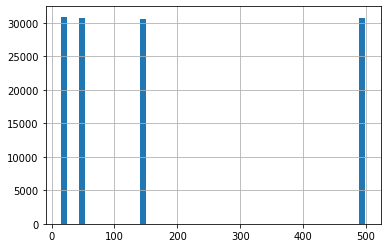

In [250]:
sales['price_of_one'].hist(bins=50)

In [251]:
sales['price_of_one'].value_counts()

499.0    30726
149.0    30620
49.9     24212
14.9     22781
14.9      7844
49.9      6576
14.9       297
Name: price_of_one, dtype: int64

Тут явно какие-то нюансы вычислений... давайте округлим все до десятой?

In [252]:
sales['price_of_one'] = sales['price_of_one'].apply(lambda x: round(float(x), 1))
sales['price_of_one'].value_counts()

14.9     30922
49.9     30788
499.0    30726
149.0    30620
Name: price_of_one, dtype: int64

Так-то лучше.

Ага, тестовые данные явно синтетичсекие - разспределения quantity и discount_percent ровные, за исключением краевых значений, а также количество записей о разных продуктах и типах лицензий примерно одинаковое. Что ж, это просто значит, что не стоит искать какие-то зависимости от стоимости лицензии или ее типа.

In [253]:
date_income = sales[sales['product']=='CL'].groupby('date')['stock_price_usd'].sum()

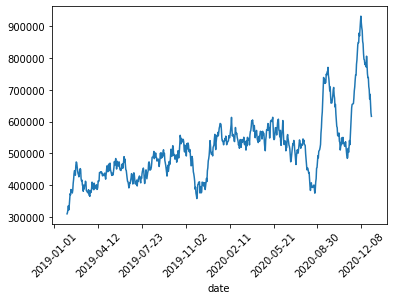

In [254]:
date_income.sort_index().rolling(30).mean().plot()
plt.xticks(rotation=45)
plt.show()

Что это за пики? Может, скидки?

<AxesSubplot:xlabel='date'>

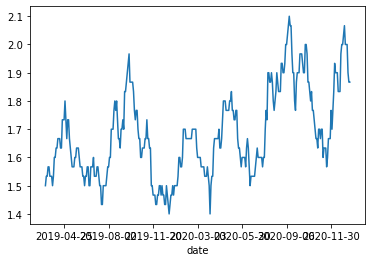

In [255]:
sales[sales['discount_percent']==100].groupby('date')['customer_id'].count().rolling(30).mean().plot()

Не, скидки какие-то рандомные.

А как шли продажи у каждой ценовой категории в отдельности?

In [256]:
date_income_prices = sales[sales['product']=='CL'].groupby(['price_of_one', 'date'])['stock_price_usd'].sum().reset_index()

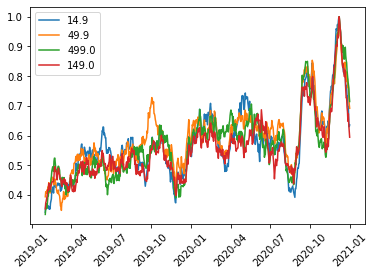

In [257]:
for price in list(sales['price_of_one'].unique()):
    s = date_income_prices[date_income_prices['price_of_one']==price][['date', 'stock_price_usd']].set_index('date').sort_index().fillna('ffill').rolling(30).mean()
    s.index = pd.to_datetime(s.index.to_series())
    s = s/s.max()
    plt.plot(s, label=price)
plt.xticks(rotation=45)
plt.legend()
plt.show()

А была ли разница в продуктах?

In [258]:
date_income_prroducts = sales.groupby(['product', 'date'])['stock_price_usd'].sum().reset_index()

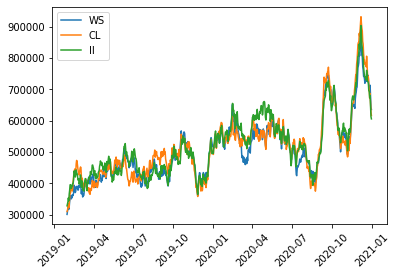

In [259]:
for product in list(sales['product'].unique()):
    s = date_income_prroducts[date_income_prroducts['product']==product][['date', 'stock_price_usd']].set_index('date').sort_index().fillna('ffill').rolling(30).mean()
    s.index = pd.to_datetime(s.index.to_series())
    # s = s/s.max()
    plt.plot(s, label=product)
plt.xticks(rotation=45)
plt.legend()
plt.show()

Ага выручка распределена равномерно даже по продуктам.

Похоже, что можно предиктить всю выручку вместе

### Предсказание.

 Сначала - линейный прогноз, в ознакомительных целях.

In [263]:
date_income = sales[sales['product']=='CL'].groupby('date')['stock_price_usd'].sum().reset_index()

date_income['date'] = pd.to_datetime(date_income['date'])

X = date_income['date'].values.astype(np.int64) // 10 ** 9
y = date_income['stock_price_usd']
reg = LinearRegression()
reg.fit(pd.DataFrame(X), y)
X_pred = pd.date_range(start="2021-01-01",end="2021-12-31")
X_pred = X_pred.values.astype(np.int64) // 10 ** 9
y_pred = reg.predict(pd.DataFrame(X_pred))

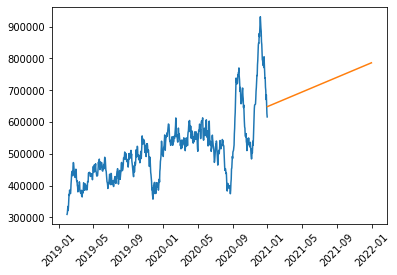

In [264]:
plt.plot(date_income['date'], date_income['stock_price_usd'].rolling(30).mean())
plt.plot(pd.date_range(start="2021-01-01",end="2021-12-31"), y_pred)
plt.xticks(rotation=45)
plt.show()

Также сохраним ряд за вычетом линейного роста.

In [265]:
X_period = pd.date_range(start="2019-01-01",end="2021-01-01")
X_period = X_period.values.astype(np.int64) // 10 ** 9
y_period = reg.predict(pd.DataFrame(X_period))
y_stat = date_income.set_index('date')['stock_price_usd'] - \
         pd.Series(y_period, index=pd.date_range(start="2019-01-01",end="2021-01-01")).dropna()

До того, как строить предсказания, надо понять, с какой зависимостью мы имеем дело. Все эти колебания - они случайные или там все-таки есть сезонность? Начнем с автокорреляции. Возьмем библиотечную функцию из statmodels. Можно посчитать просто корреляции со сдвигом, но если нет очевидной автокорреляции, то картинка получается неоднозначная и все равно вызывает еще вопросы.

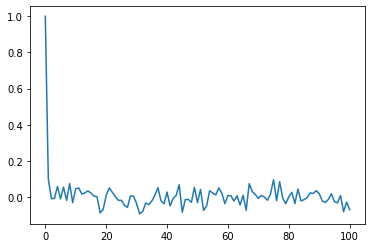

In [266]:
#Возьмем с запасом, хотя это и неправильно с точки зрения статистики
plt.plot(pacf(y_stat.dropna(), nlags=100))

Увы, автокорреляции нет, поэтому лучшее, и самое честное, что мы можем построить в отсутствии инсайтов о событиях и прогнозах рекламной активности - это построить линейный прогноз.

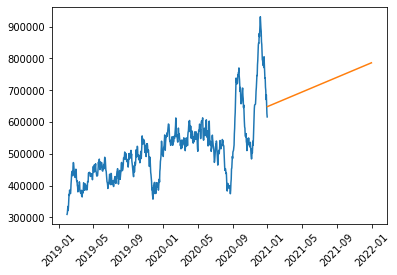

In [267]:
plt.plot(date_income['date'], date_income['stock_price_usd'].rolling(30).mean())
plt.plot(pd.date_range(start="2021-01-01",end="2021-12-31"), y_pred)
plt.xticks(rotation=45)
plt.show()

In [268]:
round(sum(y_pred), 0)

261930973.0

Итого прогнозная выручка на следующие полгода - 103 млн.

In [269]:
all_2019 = date_income[date_income['date']<'2020-01-01']['stock_price_usd'].sum()/100_000_000
all_2020 = date_income[date_income['date']>='2020-01-01']['stock_price_usd'].sum()/100_000_000
all_2021 = sum(y_pred)/100_000_000

In [270]:
(all_2021-all_2020)/all_2020, (all_2020-all_2019)/all_2019

(0.24208302541836146, 0.3268305252226613)

### Предсказание.

 Сначала - линейный прогноз, в ознакомительных целях.

In [3]:
date_income = sales[sales['product']=='CL'].groupby('date')['stock_price_usd'].sum().reset_index()

date_income['date'] = pd.to_datetime(date_income['date'])

X = date_income['date'].values.astype(np.int64) // 10 ** 9
y = date_income['stock_price_usd']
reg = LinearRegression()
reg.fit(pd.DataFrame(X), y)
X_pred = pd.date_range(start="2021-01-01",end="2021-06-01")
X_pred = X_pred.values.astype(np.int64) // 10 ** 9
y_pred = reg.predict(pd.DataFrame(X_pred))

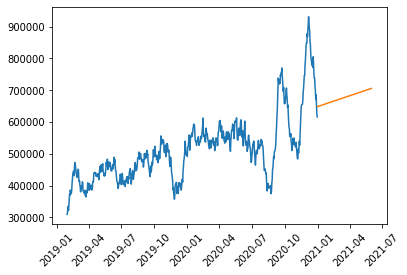

In [281]:
plt.plot(date_income['date'], date_income['stock_price_usd'].rolling(30).mean())
plt.plot(pd.date_range(start="2021-01-01",end="2021-06-01"), y_pred)
plt.xticks(rotation=45)
plt.show()

Посмотрим теперь на данные опросов.

In [4]:
dev_eco_19 = pd.read_csv('sharing_data_outside2019.csv', low_memory=False)
dev_eco_20 = pd.read_csv('2020_sharing_data_outside.csv', low_memory=False)

In [7]:
len(dev_eco_20)

23589

In [11]:
dev_eco_19_columns = dev_eco_19.columns
dev_eco_19_topics = set([col.split('.')[0] for col in dev_eco_19_columns])

dev_eco_20_columns = dev_eco_19.columns
dev_eco_20_topics = set([col.split('.')[0] for col in dev_eco_20_columns])

Так как форматы итоговых таблиц не вполне совпадают, будем держать таблицы по отдельности. 

Для частого анализа их сначала нужно привести к тождественному виду, но при количсетво групп столбцов более сотни имеет смысл рассмотривать только те, которые нас потенциально заинтересуют.

Будем сравнивать разработчиков С++ с самими собой в прошлом году. Для поиска трендов среди одних разработчиков сравнивать их с другими не имеет особого смысла. Это могло бы иметь смысл для поиска отличий в режимах работы или способов работы в команде и прочих социальных штук.

In [19]:
columns_19 = list(set([col.split('.')[0] for col in dev_eco_19.columns]))
columns_20 = list(set([col.split('.')[0] for col in dev_eco_20.columns]))

In [29]:
columns_ = set(columns_20).intersection(set(columns_19))

In [106]:
cplusplus_19 = dev_eco_19[dev_eco_19['primary_proglang.C++']=='C++']
cplusplus_20 = dev_eco_20[dev_eco_20['main']=='C++']

Вглянем на наиболее заполненные столбцы

In [99]:
theme_dict = {}
for c_main in list(columns_19):

    cc_19 = [col for col in cplusplus_19.columns if col.split('.')[0]==c_main]
    part = dev_eco_19[cc_19]
    theme_dict[c_main] = 1 - part.isna().all(axis='columns').sum()/len(cplusplus_19[cc_19])
    
themes = pd.Series(theme_dict).sort_values(ascending=False)

<AxesSubplot:>

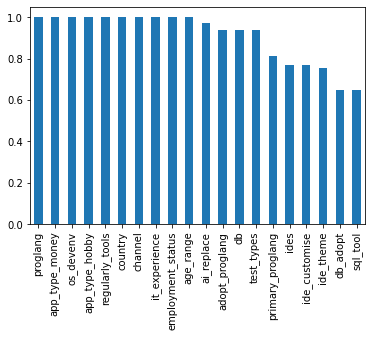

In [100]:
themes.head(20).plot.bar()

Отберем тех, у кого основной язык - С++. К сожалению, опросы 19 и 20 годов выглядят не вполне одинаково, в некоторых поменялся тип вопросов, поэтому я оставила их двумя таблицами, чтобы отдельно потом обработать не совпадающие по формату колонки.

In [107]:
cplusplus_19 = dev_eco_19[dev_eco_19['primary_proglang.C++']=='C++']
cplusplus_20 = dev_eco_20[dev_eco_20['main']=='C++']

А теперь - графики по всем остальным колонкам. Там есть жвриситика заполненности, я ее двигала, чтобы смотреть на наиболее заполненные колонки, но вообще полезно посмотреть на все, на что отвечают разработчики С++

agile_framework


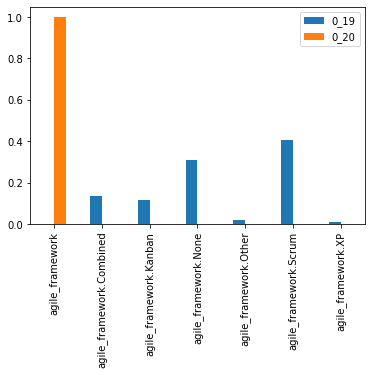

country


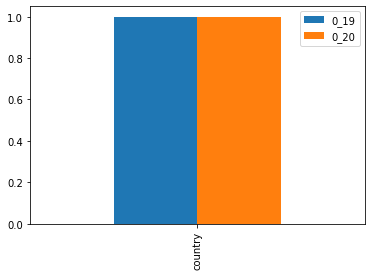

cpp_guidelines_sources


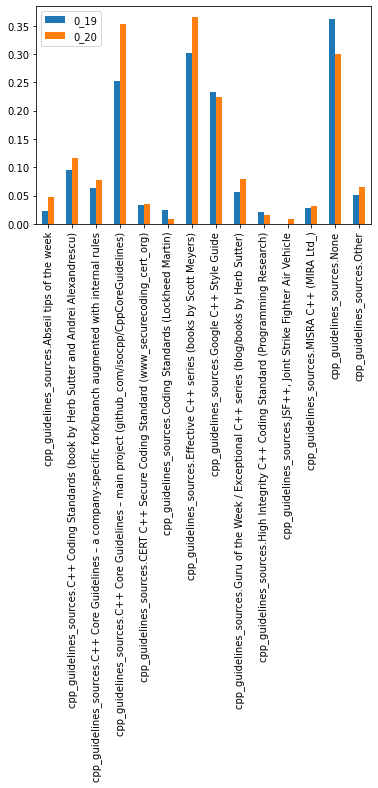

ides


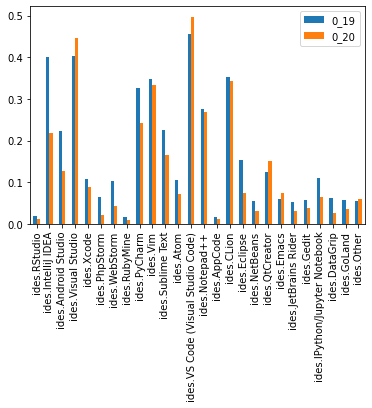

cpp_guidelines_tools


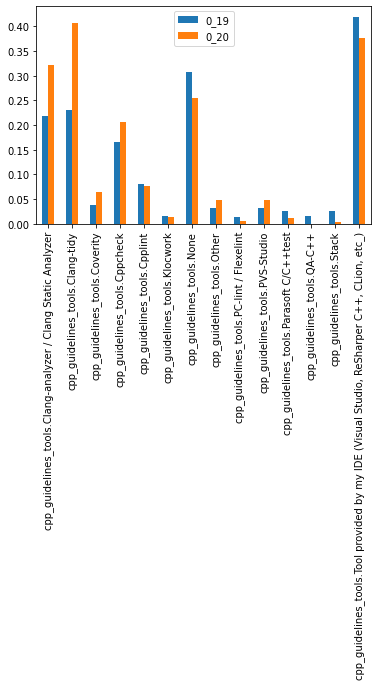

kind_of_dev


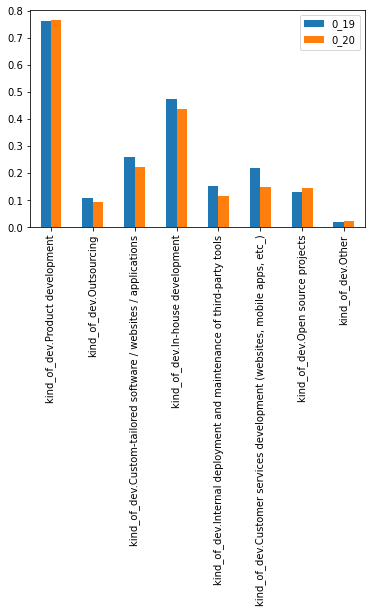

job_role


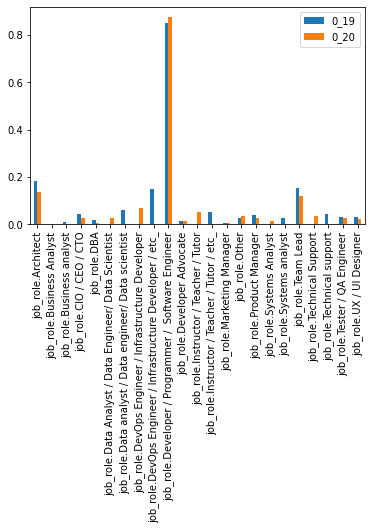

os_devenv


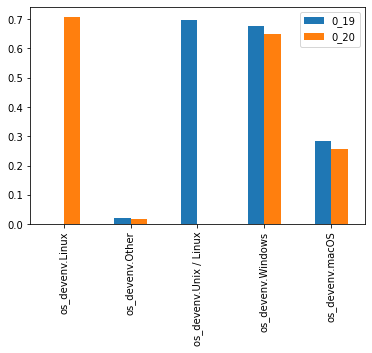

sql_tool


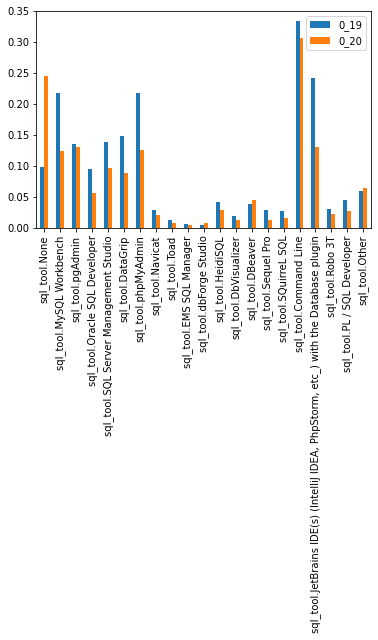

team_distributed


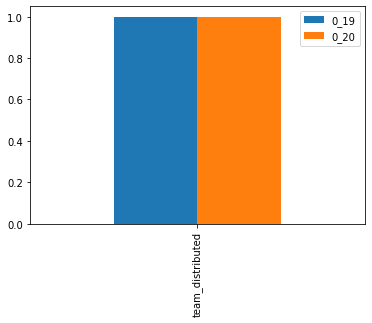

regularly_tools


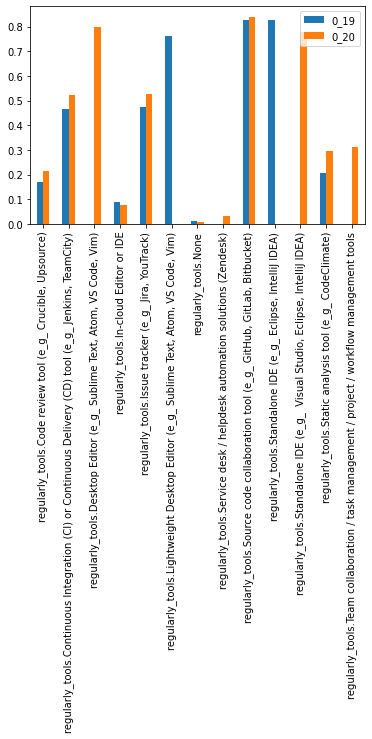

cpp_cli


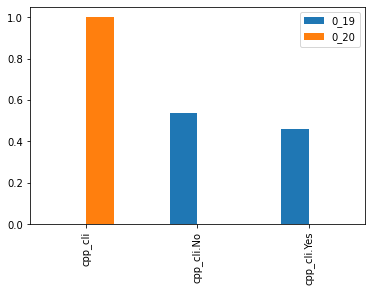

unittests_how


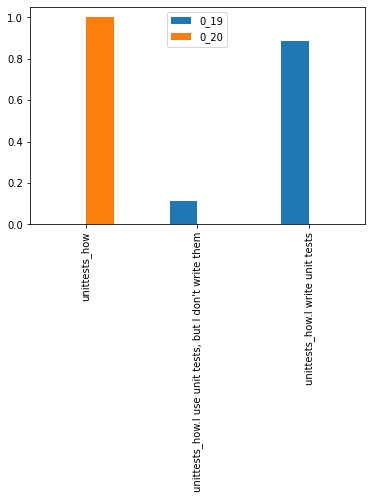

db_adopt


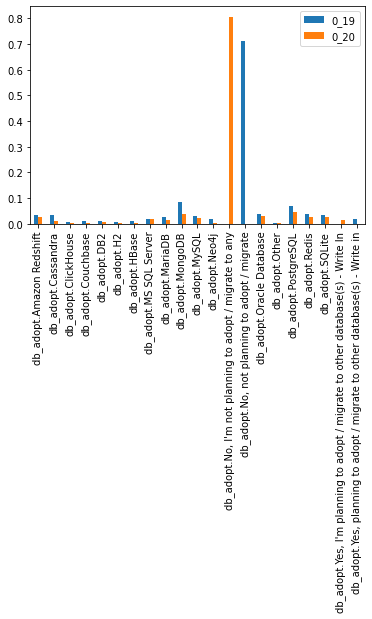

cpp_dependencymanager


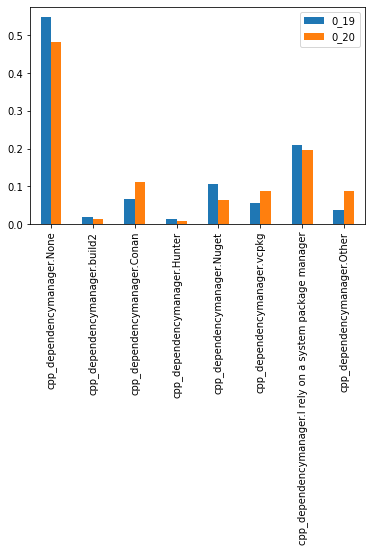

age_range


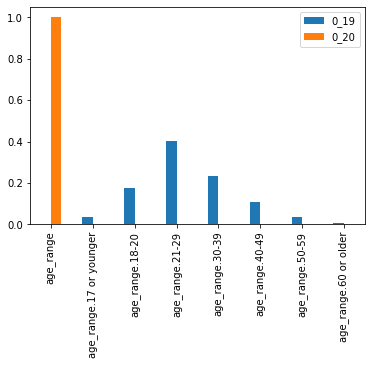

cpp_project_size


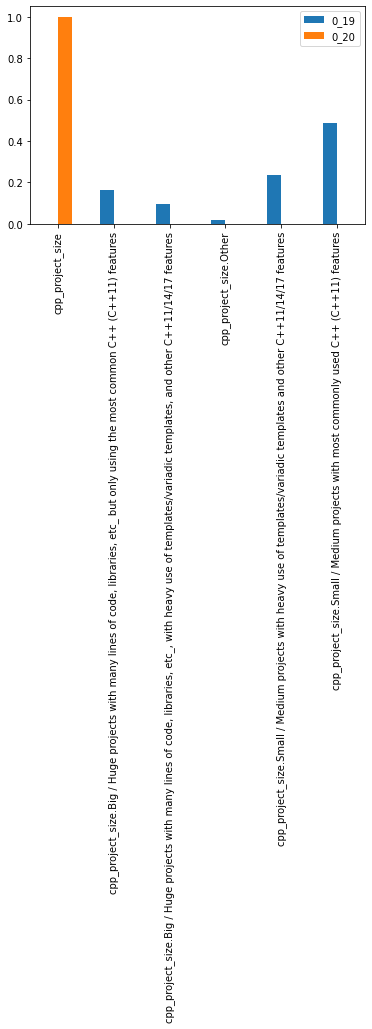

proglang


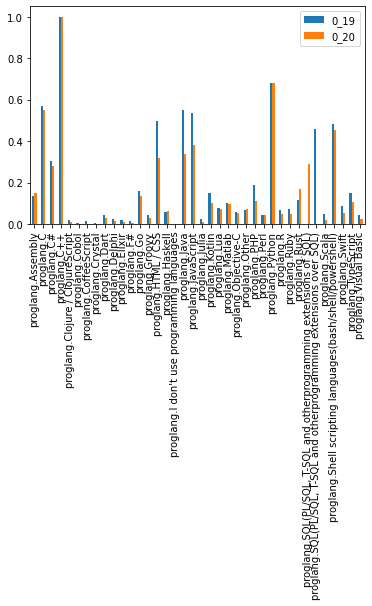

test_types


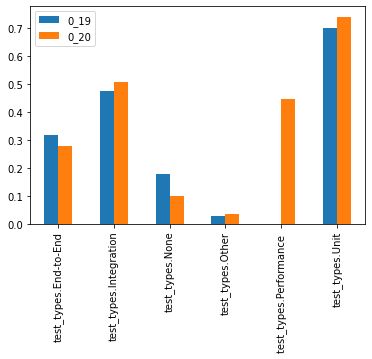

advocate


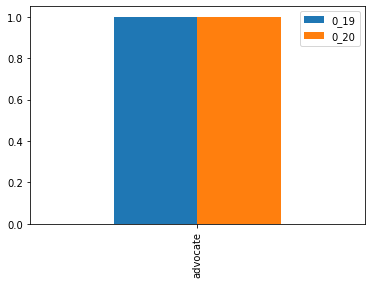

cpp_ide


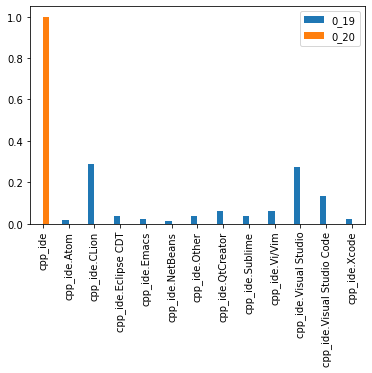

it_core


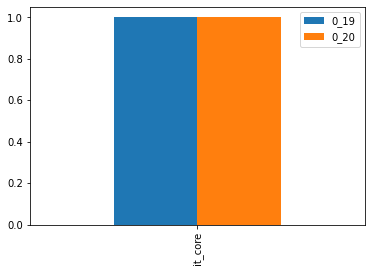

primary_proglang


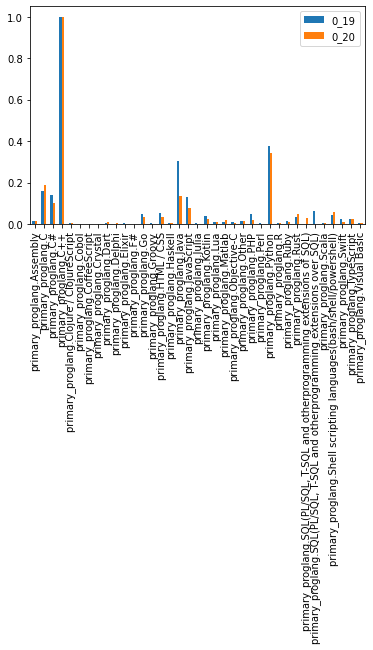

team_size


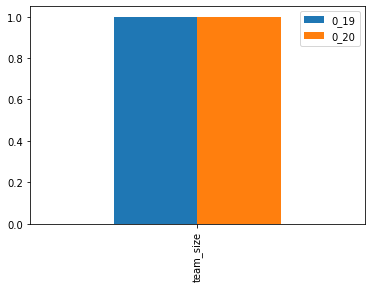

employment_status


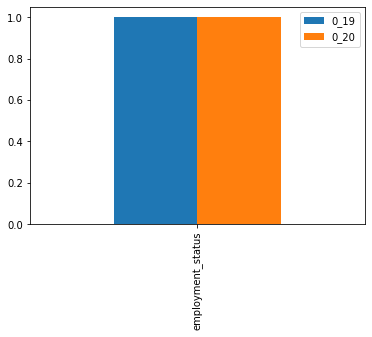

db


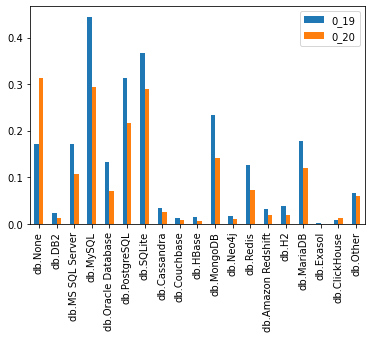

adopt_proglang


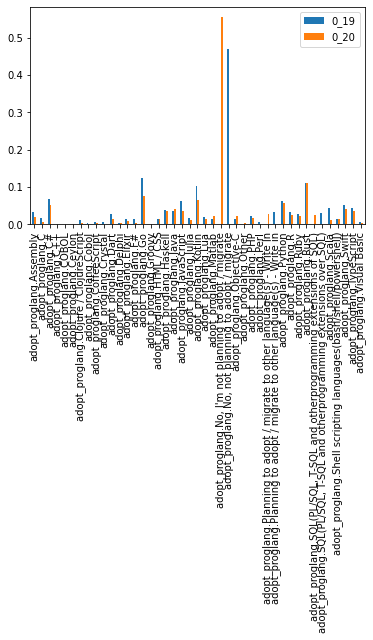

proglang_rank


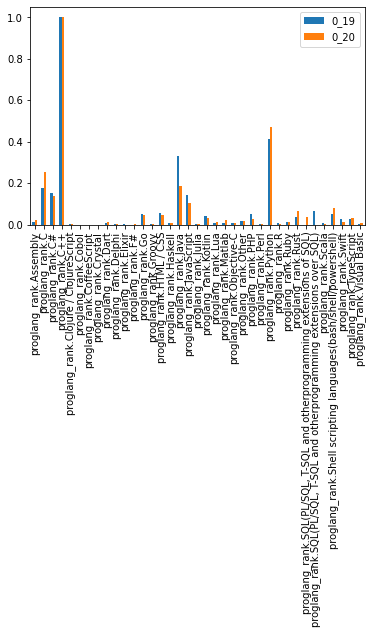

cpp_standart


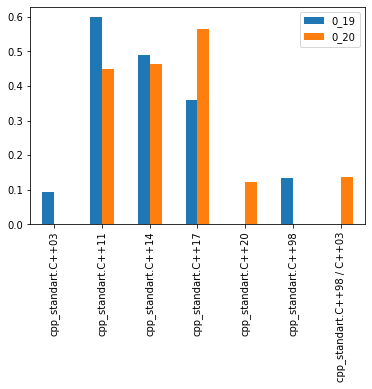

cpp_unittesting


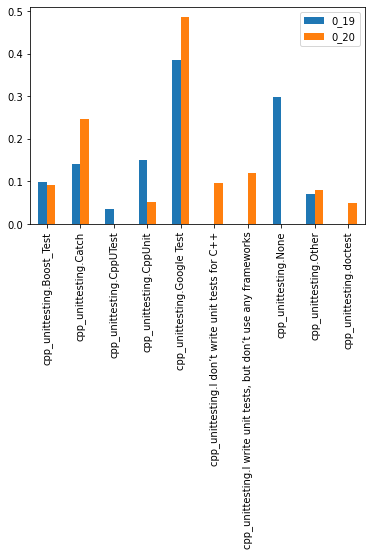

cpp_compilers


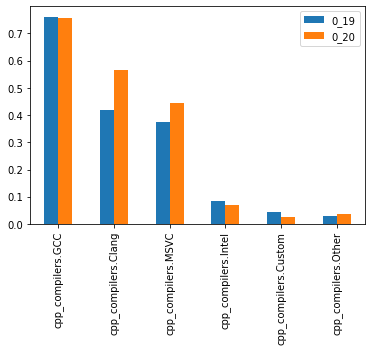

company_size


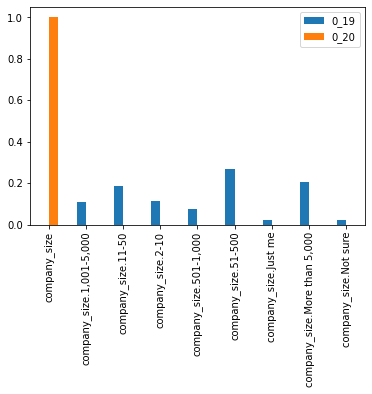

cpp_projectmodels


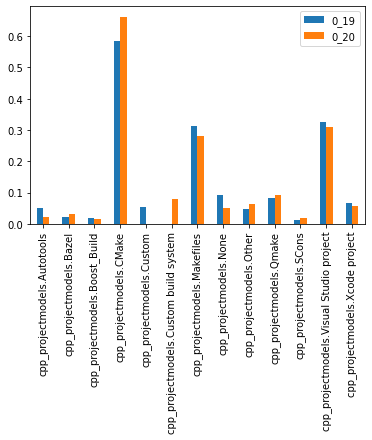

communication_tools


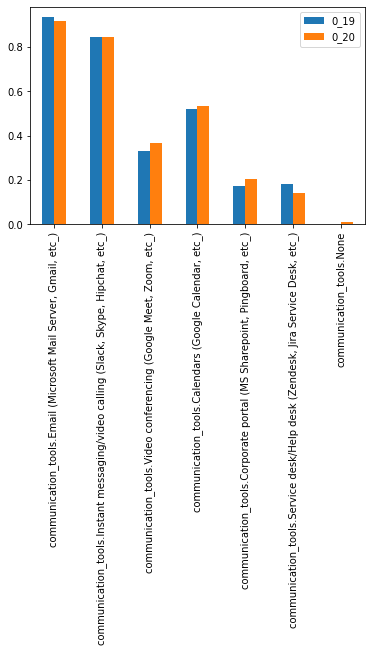

In [228]:
for c_main in list(columns_):

    cc_19 = [col for col in cplusplus_19.columns if col.split('.')[0]==c_main]
    cc_20 = [col for col in cplusplus_20.columns if col.split('.')[0]==c_main]
    if ((cplusplus_19[cc_19].isna().all(axis='columns').sum()/len(cplusplus_19[cc_19])<0.9) and \
        (cplusplus_20[cc_20].isna().all(axis='columns').sum()/len(cplusplus_20[cc_20])<0.9)):
        c19 = cplusplus_19[cc_19].notna().sum()/len(cplusplus_19[cc_19].dropna(how='all'))
        c20 = cplusplus_20[cc_20].notna().sum()/len(cplusplus_20[cc_20].dropna(how='all'))
        if len(c19.dropna())>0 or len(c20.dropna())>0:
            print(c_main)
            to_plot = c19.to_frame().join(c20.to_frame(), how='outer', lsuffix='_19', rsuffix='_20')
            to_plot.plot.bar()
            # plt.legend()
            plt.xticks(rotation=90)
            plt.show()

### Возраст

In [184]:
cc_19 = [col for col in cplusplus_19.columns if col.split('.')[0]=='age_range']
age_19 = cplusplus_19[cc_19]
age_19 = age_19.notna().astype(int)
age_19.columns = [col.split('.')[-1].replace('-', '–') for col in age_19.columns]
age_19 = age_19.sum()

In [185]:
age_20 = pd.get_dummies(cplusplus_20['age_range'])
age_20 = age_20.sum()

In [186]:
age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)

<AxesSubplot:>

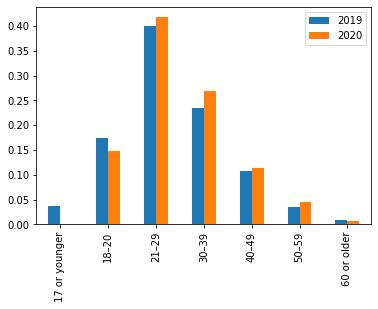

In [187]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020')).plot.bar()

### География

In [210]:
age_20 = pd.get_dummies(cplusplus_20['country'])
age_20 = age_20.sum()

age_19 = pd.get_dummies(cplusplus_19['country'])
age_19 = age_19.sum()

age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)

<AxesSubplot:>

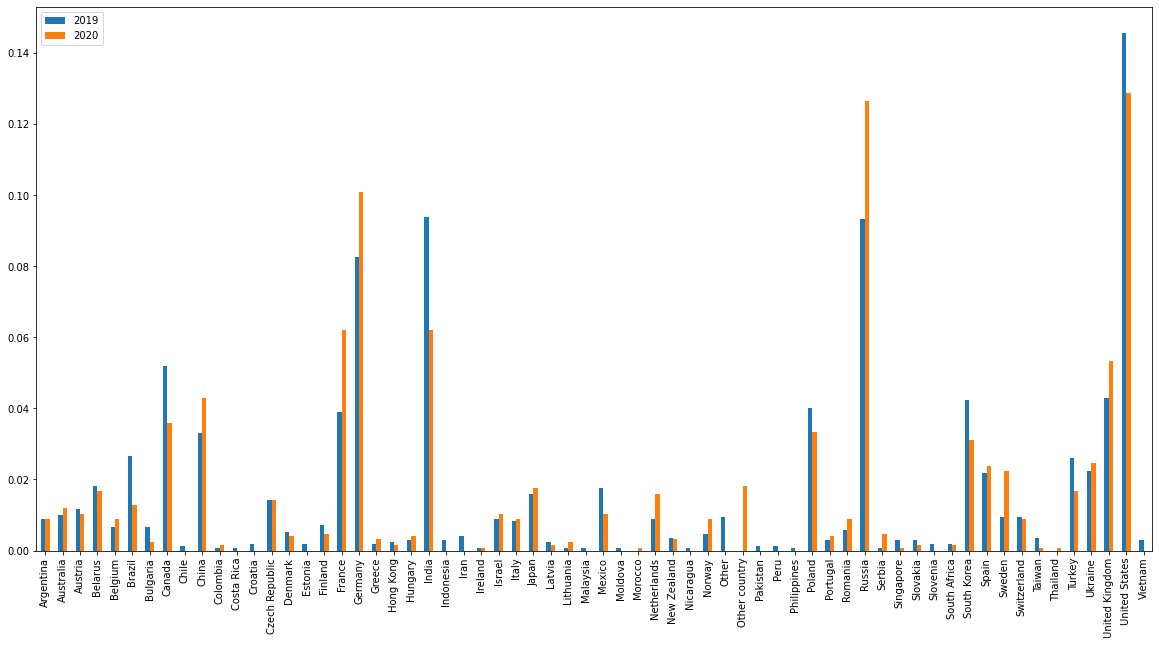

In [211]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020'), how='outer').plot.bar(figsize=(20,10))

Это не столько тренд, сколько нужно иметь в виду, что география немного изменилась и в полноценном исследовании нужно сравнивать распределния в разных странах.

### Размер проекта

In [196]:
cc_19 = [col for col in cplusplus_19.columns if col.split('.')[0]=='cpp_project_size']
age_19 = cplusplus_19[cc_19]
age_19 = age_19.notna().astype(int)
age_19.columns = [col.split('.')[-1].replace('-', '–') for col in age_19.columns]
age_19 = age_19.sum()

In [197]:
age_20 = pd.get_dummies(cplusplus_20['cpp_project_size'])
age_20.columns = [col.replace('/20', '').replace('with the', 'with') for col in age_20.columns]
age_20 = age_20.sum()

In [198]:
age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)

<AxesSubplot:>

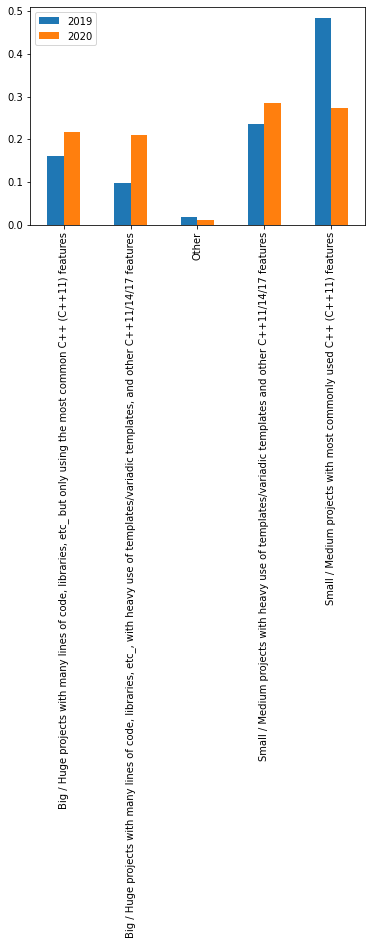

In [199]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020'), how='outer').plot.bar()

Ага, а если чисто размер?

In [200]:
cc_19 = [col for col in cplusplus_19.columns if col.split('.')[0]=='cpp_project_size']
age_19 = cplusplus_19[cc_19]
age_19 = age_19.notna().astype(int)
age_19.columns = [col.split('.')[-1].replace('-', '–') for col in age_19.columns]
age_19.columns = [col.split('projects')[0] for col in age_19.columns]
age_19 = age_19.groupby(lambda x:x, axis=1).sum()
age_19 = age_19.sum()

In [202]:
age_20 = pd.get_dummies(cplusplus_20['cpp_project_size'])
age_20.columns = [col.replace('/20', '').replace('with the', 'with') for col in age_20.columns]
age_20.columns = [col.split('projects')[0] for col in age_20.columns]
age_20 = age_20.groupby(lambda x:x, axis=1).sum()
age_20 = age_20.sum()

In [203]:
age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)

<AxesSubplot:>

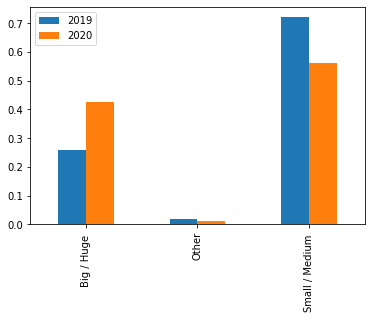

In [204]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020'), how='outer').plot.bar()

Так, тенденция участвовать в более крупных проектах.

### Юнит тесты

In [212]:
cc_19 = [col for col in cplusplus_19.columns if col.split('.')[0]=='unittests_how']
age_19 = cplusplus_19[cc_19]
age_19 = age_19.notna().astype(int)
age_19.columns = [col.split('.')[-1].replace('-', '–') for col in age_19.columns]
age_19 = age_19.sum()

In [213]:
age_20 = pd.get_dummies(dev_eco_20['unittests_how'])
age_20 = age_20.sum()

In [214]:
age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)

<AxesSubplot:>

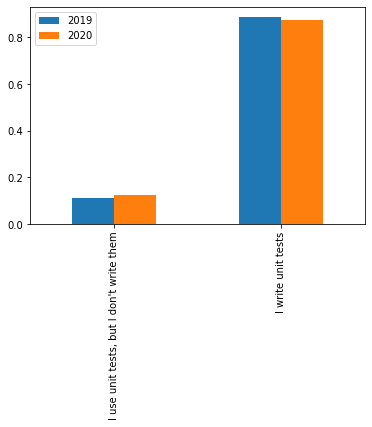

In [215]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020'), how='outer').plot.bar()

### Размер команды

In [216]:
age_20 = pd.get_dummies(cplusplus_20['team_size'])
age_20 = age_20.sum()

age_19 = pd.get_dummies(cplusplus_19['team_size'])
age_19 = age_19.sum()

age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)

<AxesSubplot:>

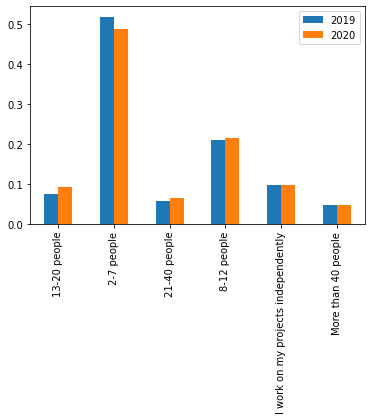

In [217]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020'), how='outer').plot.bar()

### Agile

In [231]:
cc_19 = [col for col in cplusplus_19.columns if col.split('.')[0]=='agile_framework']
age_19 = cplusplus_19[cc_19]
age_19 = age_19.notna().astype(int)
age_19.columns = [col.split('.')[-1].replace('-', '–') for col in age_19.columns]
age_19 = age_19.sum()

age_20 = pd.get_dummies(cplusplus_20['agile_framework'])
age_20 = age_20.sum()


age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)

<AxesSubplot:>

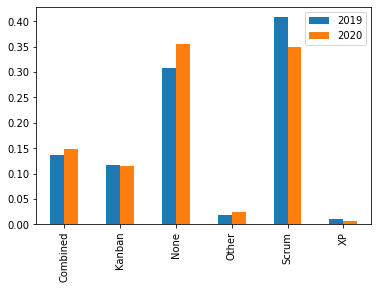

In [232]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020'), how='outer').plot.bar()

### Размер компании

In [237]:


cc_19 = [col for col in cplusplus_19.columns if col.split('.')[0]=='company_size']
age_19 = cplusplus_19[cc_19]
age_19 = age_19.notna().astype(int)
age_19.columns = [col.split('.')[-1] for col in age_19.columns]
age_19 = age_19.sum()

age_20 = pd.get_dummies(cplusplus_20['company_size'])
age_20 = age_20.sum()

age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)

<AxesSubplot:>

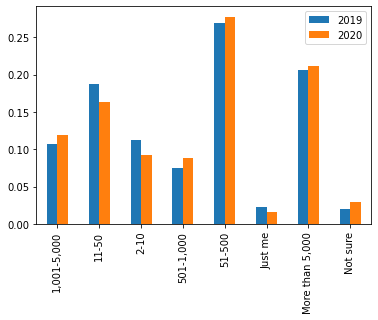

In [238]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020'), how='outer').plot.bar()

Ага, несколько выросла доля работающих в больших компаниях

### Вид трудоустройства

In [218]:
age_20 = pd.get_dummies(cplusplus_20['employment_status'])
age_20 = age_20.sum()

age_19 = pd.get_dummies(cplusplus_19['employment_status'])
age_19 = age_19.sum()

age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)


<AxesSubplot:>

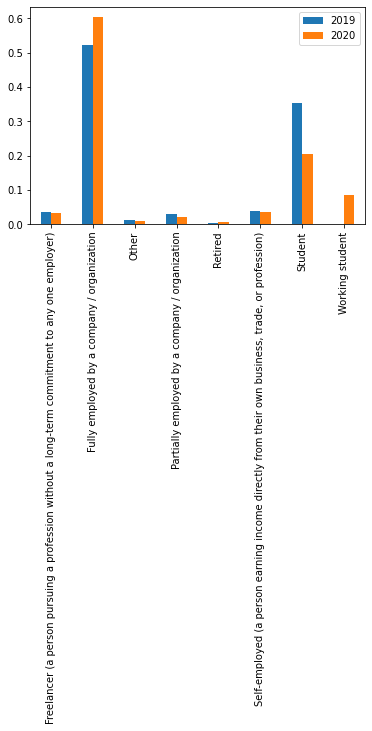

In [219]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020'), how='outer').plot.bar()

### IDE

In [224]:
cc_19 = [col for col in cplusplus_19.columns if col.split('.')[0]=='cpp_ide']
age_19 = cplusplus_19[cc_19]
age_19 = age_19.notna().astype(int)
age_19.columns = [col.split('.')[-1].replace('-', '–') for col in age_19.columns]
age_19 = age_19.sum()

In [225]:
age_20 = pd.get_dummies(dev_eco_20['cpp_ide'])
age_20 = age_20.sum()

In [226]:
age_19 = age_19/age_19.sum(axis=0)
age_20 = age_20/age_20.sum(axis=0)

<AxesSubplot:>

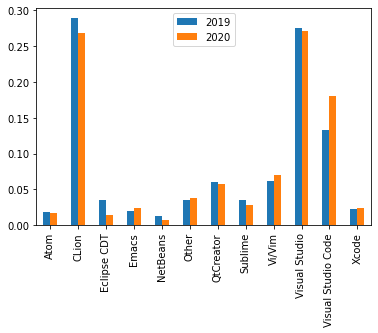

In [227]:
age_19.to_frame(name='2019').join(age_20.to_frame(name='2020'), how='outer').plot.bar()

### Вывод.

Чуть-чуть изменилось распределение возрастов и есть факт миграции среднего разработчика С++ из США в Россию. Это не столько тренд, сколько факт, про который нужно помнить и проверять все выводы с учетом этого факта. Также они стали предпочитать более крупные проекты и более крупные компании и перешли на обновленные стандарты, но это перманентный тренд. 

А так из интересного - разработчики стали использовать бесплатные Clang-analyzer и Clang-tidy, став несколько меньше пользоваться остальныемя ide, отдам предпостение Visual studio. Стоит отметить, что, судя по первой выдаче в поисковике, у них Clang стоит по дефолту. Не факт, что это имеет значение, но некая связь может иметь место.

### Тексты вопросов на stackOverflow по тегу Clion.

In [139]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [173]:
posts = pd.read_csv('QueryResults-2.csv')

Самое большое соотношение полезности к потраченным усилиям дает метод поиска n-грамм с помощью tfidf. Это быстро, незатратно и дает быстрое понимание происходящего. Все остальные методы требуют тщательного анализа, не подходящего под формат тестового задания.

Искать будем в названиях, так как там человек пытается максимально коротко и без лишних слов сформулировать проблему, пользуясь ключевыми словами. По сути, делая за нас половину работы.

In [175]:
posts = posts[(posts['Score']>0) & posts['Tags'].str.contains('clion')]

In [191]:
posts['text'] = posts['Title'].apply(lambda x: re.sub(r'<.+?>', '', x))

/var/folders/jy/psw1qw4n5_g5x0828wrpkwdm0000gn/T/ipykernel_4197/3907027001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['text'] = posts['Title'].apply(lambda x: re.sub(r'<.+?>', '', x))


In [213]:
tfidf = TfidfVectorizer(max_df=0.9, ngram_range=(2, 3), stop_words='english')
X = tfidf.fit_transform(posts['text'].to_list())

In [214]:
pd.Series(dict(zip(tfidf.get_feature_names_out(), X.sum(axis=0).tolist()[0]))).sort_values().tail(40)

standard libraries          0.386928
clion remote machine        0.386928
libraries clion             0.386928
standard libraries clion    0.386928
libraries clion remote      0.386928
won hit                     0.447214
won hit clion               0.447214
make_heap pop_heap          0.447214
pop_heap ok push_heap       0.447214
add linker                  0.447214
add linker flags            0.447214
ok push_heap                0.447214
pop_heap ok                 0.447214
setup mkl                   0.447214
setup mkl linux             0.447214
flags clion                 0.447214
linux cmake                 0.447214
temp directory              0.447214
filling temp directory      0.447214
linker flags clion          0.447214
make_heap pop_heap ok       0.447214
filling temp                0.447214
linker flags                0.447214
mkl linux                   0.447214
hit clion                   0.447214
breakpoints won hit         0.447214
clion filling               0.447214
m

Итого у пользователей возникли проблемы с запуском на удаленной машине, с support concepts, которые имеют отношение к уже упомянутому Clang, с заполнением temp directory файлами, а также setup mkl, pop_heap и push_heap.